In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
import compression.IMNN.IMNN_delfi as IMNN
%matplotlib inline

In [3]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb')), 
                                                           lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, 
                                                           nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    simulation = CosmicShearSimulator.simulate(theta, seed)
    nmodes = simulation.shape[0]
    nz = simulation.shape[1]
    d = np.zeros((int(nmodes*nz*(nz+1)/2)))
    for i in range(nmodes):
        x = np.tril(simulation[i, :, :])
        x = x[np.nonzero(x)]
        d[i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x    
    #indices = simulator_args[0]
    #return simulation[indices].flatten()
    return d
    
simulator_args = None#[np.tril_indices(CosmicShearSimulator.shape[-1], 0)]

In [4]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

Derivative simulations: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


(1000, 550) (100, 5, 550) (100, 5, 550) (1000, 550) (100, 5, 550) (100, 5, 550)
[550, 275, 137, 68, 34, 17, 8]
saving model as compression/cosmic_shear.meta
saving the graph as compression/cosmic_shear.meta


100%|██████████| 100/100 [00:05<00:00, 27.33it/s, detF=3.19e+21, lndetF_test=1.48e+21]


saving the graph as compression/cosmic_shear.meta


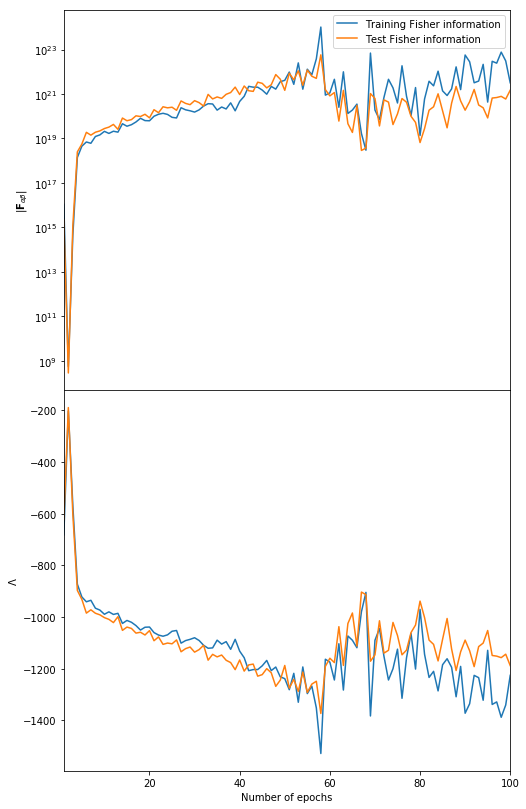

In [5]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))

# Number of parameters to train IMNN
initial_sims = 1000

# Filename for saving IMNN
filename = 'cosmic_shear'

# Get shape of the simulation
shape = list(simulator(theta_fiducial, 0, simulator_args).shape)

# Build training simulations for IMNN (andsave them) and initialise IMNN
compression_network = IMNN.get_network(simulator, simulator_args, shape, theta_fiducial, h, initial_sims, filename, make_simulations = True)

# Train IMNN
# Number of training epochs
num_epochs = 100

IMNN.train_IMNN(compression_network, num_epochs)
IMNN.plot_train_history(compression_network)

# MLE compression
compressor = IMNN.IMNN_compressor
compressor_args = compression_network

# Pull out Fisher matrix inverse
Finv = np.linalg.inv(compression_network.history['test F'][-1])

In [6]:
import pickle
with open("simulations/cosmic_shear.pickle", "rb") as file:
    data = pickle.load(file)

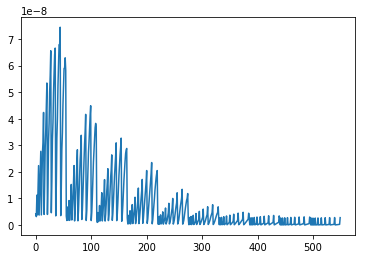

In [7]:
plt.plot(data["x_central"][0])

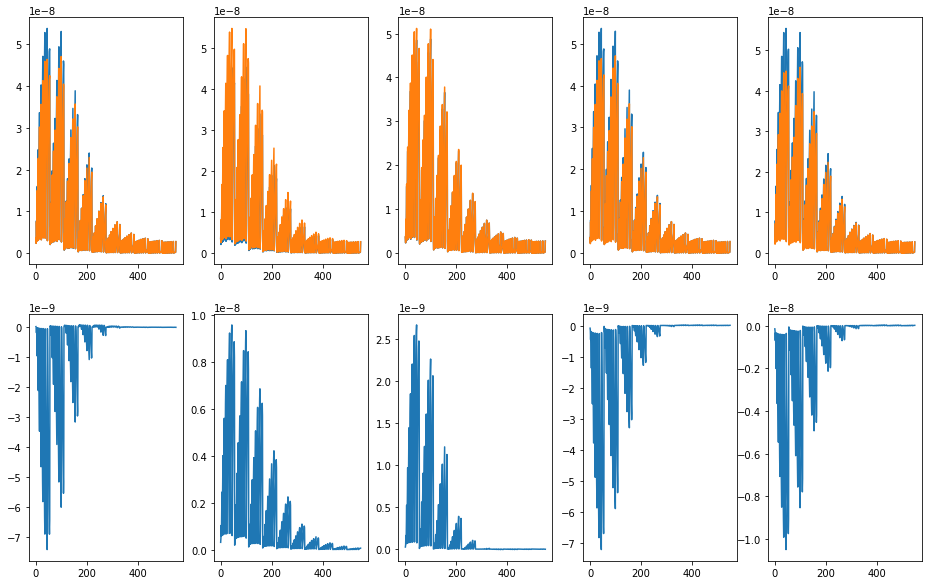

In [8]:
fig, ax = plt.subplots(2, 5, figsize = (16, 10))

for j in range(len(data["x_m"][0])):
    ax[0, j].plot(data["x_m"][0, j])
    ax[0, j].plot(data["x_p"][0, j])
    ax[1, j].plot(data["x_p"][0, j] - data["x_m"][0, j])

In [9]:
### LOAD IN THE DATA VECTOR ###
data = compressor(simulator(theta_fiducial, 42, simulator_args), compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN maximum likelihood estimate = ", data)
print("Fisher forecast = ", np.sqrt(np.diag(Finv)))

Fiducial parameter values =  [0.3  0.8  0.05 0.7  0.96]
IMNN maximum likelihood estimate =  [0.29880616 0.8009205  0.05047334 0.6977028  0.9578386 ]
Fisher forecast =  [0.00844914 0.00629559 0.00322357 0.0162954  0.0144346 ]


In [10]:
## Create the MDN
NDE = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

## Create the MAF
#NDE = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh)

In [11]:
# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, NDE, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/")

In [ ]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining(200000, prior, epochs=500, patience=100)

Sample parameters:   1%|          | 1688/200000 [00:00<00:11, 16871.05it/s]

Generating fisher pre-training data...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training the neural density estimator...


Epochs:   0%|          | 2/500 [00:23<1:37:54, 11.80s/it, train_loss=9.71, val_loss=12.7]

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, compressor_args = compressor_args)

In [ ]:
plt.close()
columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 15,
                 'legend.fontsize': 15,
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})

# Trace plot of the training and validation loss as a function of the number of simulations ran
plt.scatter(DelfiMAF.sequential_nsims, DelfiMAF.sequential_training_loss, s = 20, alpha = 0.5)
plt.plot(DelfiMAF.sequential_nsims, DelfiMAF.sequential_training_loss, color = 'red', lw = 2, alpha = 0.5, label = 'training loss')
plt.scatter(DelfiMAF.sequential_nsims, DelfiMAF.sequential_validation_loss, s = 20, alpha = 0.5)
plt.plot(DelfiMAF.sequential_nsims, DelfiMAF.sequential_validation_loss, color = 'blue', lw = 2, alpha = 0.5, label = 'validation loss')


#plt.fill_between(DelfiMAF.sequential_nsims, (DelfiMAF.sequential_validation_loss[-1]-0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), 
#                 (DelfiMAF.sequential_validation_loss[-1]+0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), color = 'grey', alpha = 0.2 )

plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
#plt.savefig('../../paper_II/plots/convergence_fixedII.pdf')
plt.tight_layout()
plt.legend()
plt.show()